In [1]:
from keras.layers import Input, Conv2D, Dense, Flatten, Reshape, UpSampling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [3]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

In [5]:
base_dir = '/scratch/jurkat_ifc/ch3_dataset'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [7]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 56x56
        patches_out -- tensor of the original patches center cropped to 48x48 
                       and then downsampled to 24x24
    
    """
    files_patches = listdir(dir_patches)
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_orig = imageio.imread(dir_patches + '/' + file_patch)
        patch_in = np.zeros((input_patch_size, input_patch_size))
        patch_in[: 55, : 55] = patch_orig
        patch_in[55, :] = patch_in[54, :]
        patch_in[:, 55] = patch_in[:, 54]
         
        patch_out = patch_in[5: 53, 5: 53]  # center-crop to 48x48 (original BRIEF input patch size)
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    patches_in = np.expand_dims(patches_in, -1)
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    patches_out = np.expand_dims(patches_out, -1)
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [8]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (25809, 56, 56, 1) ; out (25809, 24, 24, 1)
in (3227, 56, 56, 1) ; out (3227, 24, 24, 1)


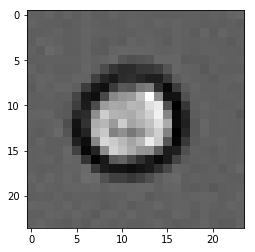

In [17]:
plt.imshow(np.array(y_validation[25, :, :, 0] * 255, dtype=np.uint8), cmap='gray')

In [19]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [24]:
brief_ae = load_model('/home/niaki/Projects/learned-brief/weights_pub/learned_brief_ae_20200605.h5')

In [ ]:
model_version = '0.0.0.0_pretrainedLearnedBRIEF_output24X24'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(image_datagen.flow(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_step4_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
 2813/25809 [==>...........................] - ETA: 14:48 - loss: 0.6388